In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import progeny
import pandas as pd
import scipy.stats
import scanpy_helpers as sh
import itertools
from tqdm.auto import tqdm

sc.set_figure_params(figsize=(4, 4))

In [3]:
adata = sc.read_h5ad("../../data/30_merge_adata/adata_scvi_annotated.h5ad")

In [4]:
adata_malignant_b = sc.read_h5ad(
    "../../data/40_cluster_analysis/adata_malignant_b_cells.h5ad"
)

In [5]:
artifact_dir = "../../data/70_downstream_analyses/pathway_analysis"

In [6]:
!mkdir -p {artifact_dir}

# Progeny

In [7]:
model = progeny.load_model(
    organism="Human",  # If working with mouse, set to Mouse
    top=1000,  # For sc we recommend ~1k target genes since there are dropouts
)

In [8]:
progeny.run(
    adata,
    model,
    center=True,  # Center gene expression by mean per cell
    num_perm=0,  # Simulate m random activities
    norm=True,  # Normalize by number of edges to correct for large regulons
    scale=True,  # Scale values per feature so that values can be compared across cells
)

7353 genes found


## healthy B vs malignant B

In [9]:
adata_pw = progeny.extract(adata)

In [10]:
adata_pw.obs["cell_type"].unique()

['malignant B cell (dividing)', 'malignant B cell', 'T cell', 'healthy B cell', 'Plasma cell']
Categories (5, object): ['Plasma cell', 'T cell', 'healthy B cell', 'malignant B cell', 'malignant B cell (dividing)']

In [11]:
pb_pw = sh.pseudobulk.pseudobulk(
    adata_pw[adata_pw.obs["cell_type"].isin(["malignant B cell", "healthy B cell"]), :],
    aggr_fun=np.mean,
    groupby=["patient", "cell_type"],
)
pb_pw.obs["cell_type"] = pb_pw.obs["cell_type"].str.replace(" cell", "")

In [12]:
pb_pw._sanitize()

/data/scratch/sturm/conda/envs/2021-hairy-cell-leukemia-wolf-scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'patient' as categorical
/data/scratch/sturm/conda/envs/2021-hairy-cell-leukemia-wolf-scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


In [13]:
sc.tl.pca(pb_pw)
sc.tl.dendrogram(
    pb_pw, groupby=["patient", "cell_type"], use_rep="X_pca", linkage_method="average"
)

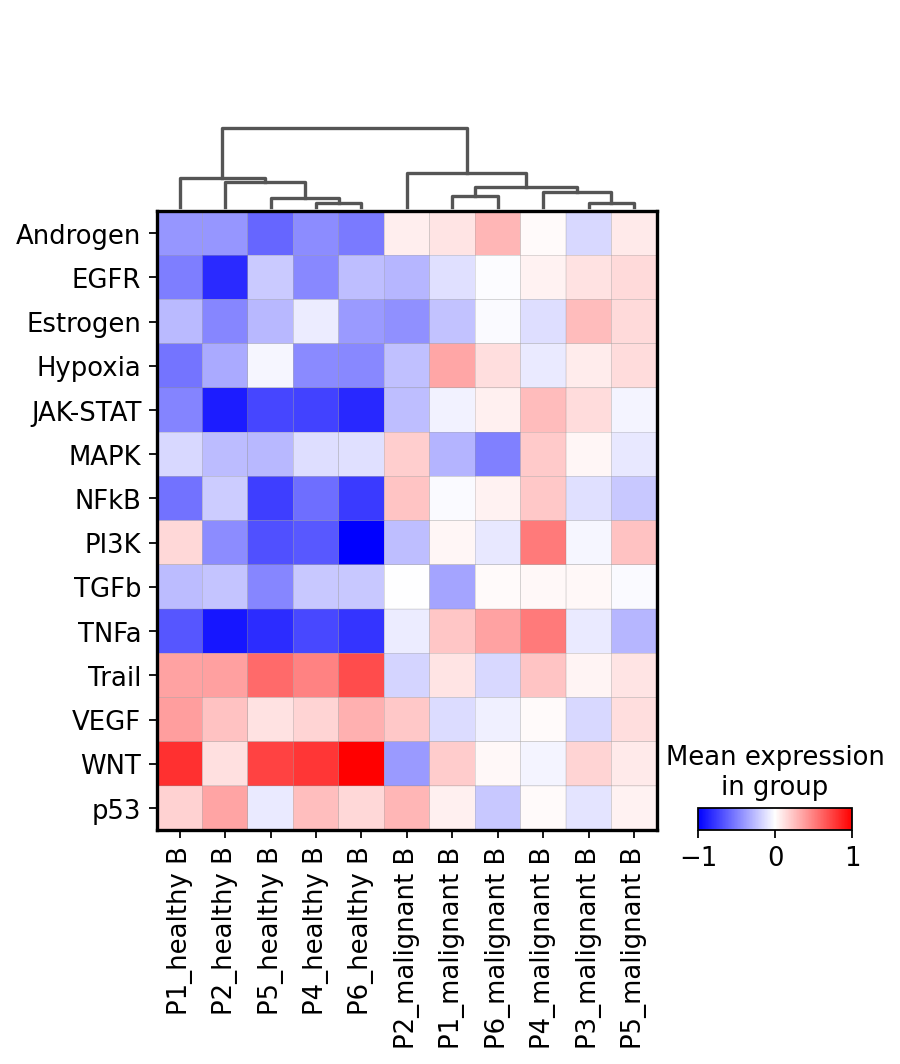

In [14]:
fig = sc.pl.matrixplot(
    pb_pw,
    var_names=pb_pw.var_names,
    groupby=["patient", "cell_type"],
    cmap="bwr",
    swap_axes=True,
    dendrogram=True,
    vmin=-1,
    vmax=1,
    return_fig=True,
)
fig.savefig(
    f"{artifact_dir}/progeny_healthy_vs_malignant_b_clustered_heatmap.pdf",
    bbox_inches="tight",
)

In [15]:
pb_pw.obs

,patient,cell_type,n_obs
0,P1,malignant B,421
1,P1,healthy B,21
2,P3,malignant B,13900
3,P2,malignant B,8061
4,P2,healthy B,149
5,P4,malignant B,3824
6,P4,healthy B,382
7,P6,malignant B,4253
8,P6,healthy B,74
9,P5,malignant B,5292


In [16]:
res = (
    sh.compare_groups.lm.test_lm(
        pb_pw,
        "~ C(cell_type, Treatment('healthy B')) + patient",
        groupby="cell_type",
        contrasts="Treatment('healthy B')",
    )
    .pipe(sh.util.fdr_correction)
    .sort_values("fdr")
)

  0%|          | 0/14 [00:00<?, ?it/s]

In [17]:
res

,coef,intercept,pvalue,variable,group,fdr
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.591528,-0.448984,0.000864,Androgen,malignant B,0.004625
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.407510,-0.516594,0.001982,EGFR,malignant B,0.004625
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.728988,-0.627101,0.001981,JAK-STAT,malignant B,0.004625
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.618037,-0.594491,0.001339,NFkB,malignant B,0.004625
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.928016,-0.682170,0.001747,TNFa,malignant B,0.004625
"C(cell_type, Treatment('healthy B'))[T.malignant B]",-0.724177,0.863471,0.001151,WNT,malignant B,0.004625
"C(cell_type, Treatment('healthy B'))[T.malignant B]",-0.475937,0.470777,0.012174,Trail,malignant B,0.024349
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.420501,-0.306628,0.045080,Hypoxia,malignant B,0.078890
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.716947,-0.265790,0.069069,PI3K,malignant B,0.097873
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.212321,-0.416273,0.069910,TGFb,malignant B,0.097873


In [18]:
ch = sh.compare_groups.pl.plot_lm_result_altair(res, p_cutoff=1)
ch.save(f"{artifact_dir}/progeny_healthy_vs_malignant_b_lm_heatmap.svg")
ch.display()

WARN Channel size should not be used with an unsorted discrete field.


alt.LayerChart(...)

In [19]:
sh.colors.plot_palette("patient")

alt.Chart(...)

In [20]:
# reorder for proper ordering of legend
pb_pw = pb_pw[
    pb_pw.obs.sort_values(["patient", "cell_type"]).index,
]

In [21]:
ch = sh.pairwise.plot_paired_fc(
    pb_pw,
    groupby="cell_type",
    paired_by="patient",
    metric="diff",
    var_names=res["variable"].tolist(),
    de_res_df=res,
    pvalue_col="fdr",
    var_col="variable",
)
ch.save(f"{artifact_dir}/progeny_healthy_vs_malignant_b_fold_change_bar_chart.svg")
ch.display()

/home/sturm/projects/2021/hairy_cell_leukemia_wolf/lib/scanpy_helpers/scanpy_helpers/pairwise.py:80: UserWarning: 1 unpaired samples removed
  warnings.warn(f"{removed_samples} unpaired samples removed")


alt.LayerChart(...)

In [22]:
res

,coef,intercept,pvalue,variable,group,fdr
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.591528,-0.448984,0.000864,Androgen,malignant B,0.004625
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.407510,-0.516594,0.001982,EGFR,malignant B,0.004625
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.728988,-0.627101,0.001981,JAK-STAT,malignant B,0.004625
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.618037,-0.594491,0.001339,NFkB,malignant B,0.004625
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.928016,-0.682170,0.001747,TNFa,malignant B,0.004625
"C(cell_type, Treatment('healthy B'))[T.malignant B]",-0.724177,0.863471,0.001151,WNT,malignant B,0.004625
"C(cell_type, Treatment('healthy B'))[T.malignant B]",-0.475937,0.470777,0.012174,Trail,malignant B,0.024349
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.420501,-0.306628,0.045080,Hypoxia,malignant B,0.078890
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.716947,-0.265790,0.069069,PI3K,malignant B,0.097873
"C(cell_type, Treatment('healthy B'))[T.malignant B]",0.212321,-0.416273,0.069910,TGFb,malignant B,0.097873


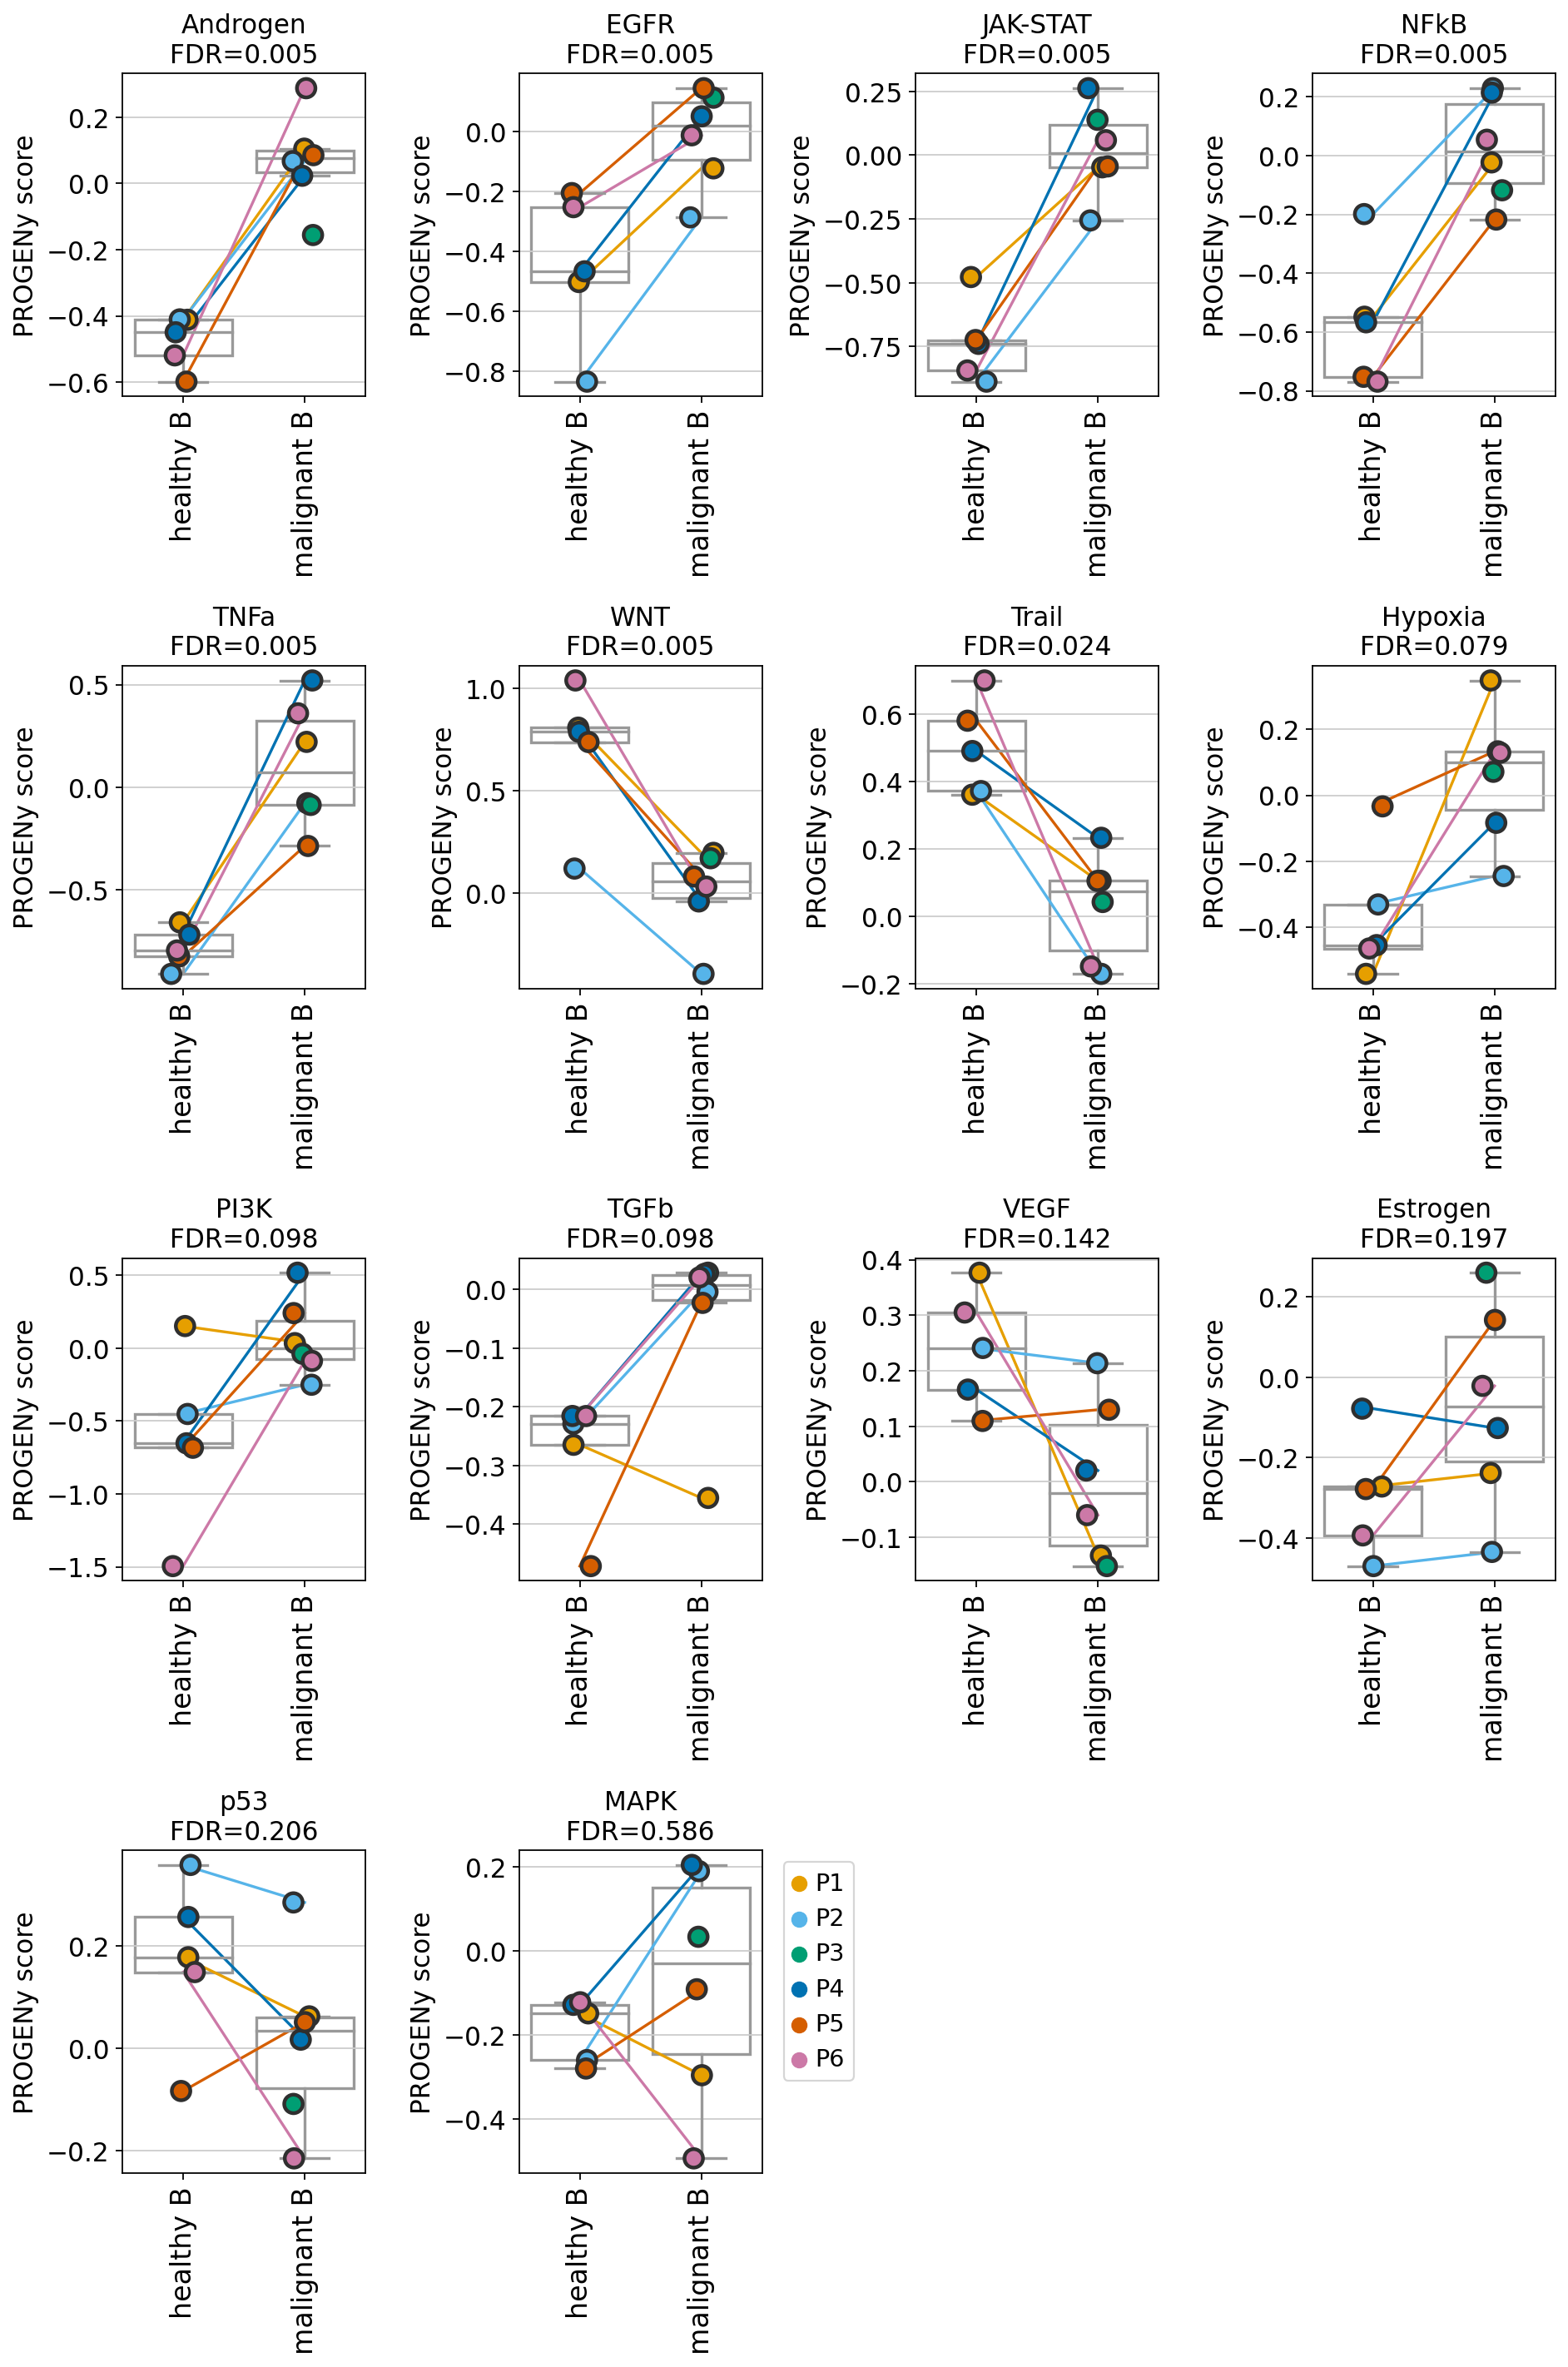

In [23]:
sns.set_palette(sns.color_palette(sh.colors.COLORS.patient.values()))
fig = sh.pairwise.plot_paired(
    pb_pw,
    groupby="cell_type",
    paired_by="patient",
    var_names=res["variable"].tolist(),
    ylabel="PROGENy score",
    pvalues=res["fdr"].tolist(),
    pvalue_template="FDR={:.3f}",
    boxplot_kwargs={"color": "white"},
    panel_size=(3, 4.5),
    return_fig=True,
    rotate_x=90,
)
fig.savefig(
    f"{artifact_dir}/progeny_healthy_vs_malignant_b_paired_boxplot.pdf",
    bbox_inches="tight",
)

## SR vs LR (timepoint T0)

In [24]:
pb_pw_sr_lr = sh.pseudobulk.pseudobulk(
    adata_pw[
        (adata_pw.obs["timepoint"] == "T0")
        & (adata_pw.obs["cell_type"] == "malignant B cell"),
        :,
    ],
    groupby=["patient", "response"],
    aggr_fun=np.mean,
)

In [25]:
pb_pw_sr_lr.obs

,patient,response,n_obs
0,P2,short_term,3353
1,P4,long_term,3824
2,P6,long_term,4253
3,P3,short_term,1109
4,P5,long_term,5292


In [26]:
# reorder for proper ordering of legend
pb_pw_sr_lr = pb_pw_sr_lr[
    pb_pw_sr_lr.obs.sort_values(["patient", "response"]).index,
]

In [27]:
res = sh.compare_groups.lm.test_lm(
    pb_pw_sr_lr,
    "~ C(response, Treatment('long_term'))",
    groupby="response",
    contrasts="Treatment('long_term')",
).sort_values("pvalue")

Trying to set attribute `.obs` of view, copying.


  0%|          | 0/14 [00:00<?, ?it/s]

In [28]:
res

,coef,intercept,pvalue,variable,group
"C(response, Treatment('long_term'))[T.short_term]",-0.398575,0.061137,0.222846,EGFR,short_term
"C(response, Treatment('long_term'))[T.short_term]",-0.269935,0.059576,0.240911,Hypoxia,short_term
"C(response, Treatment('long_term'))[T.short_term]",-0.173240,0.022822,0.355161,WNT,short_term
"C(response, Treatment('long_term'))[T.short_term]",-0.378386,0.223133,0.359715,PI3K,short_term
"C(response, Treatment('long_term'))[T.short_term]",-0.183460,0.092175,0.417971,JAK-STAT,short_term
"C(response, Treatment('long_term'))[T.short_term]",-0.083526,0.132184,0.522903,Androgen,short_term
"C(response, Treatment('long_term'))[T.short_term]",0.115263,-0.049051,0.578706,p53,short_term
"C(response, Treatment('long_term'))[T.short_term]",-0.113991,0.062798,0.625340,Trail,short_term
"C(response, Treatment('long_term'))[T.short_term]",-0.173335,0.198362,0.625574,TNFa,short_term
"C(response, Treatment('long_term'))[T.short_term]",0.092247,0.016845,0.632167,NFkB,short_term


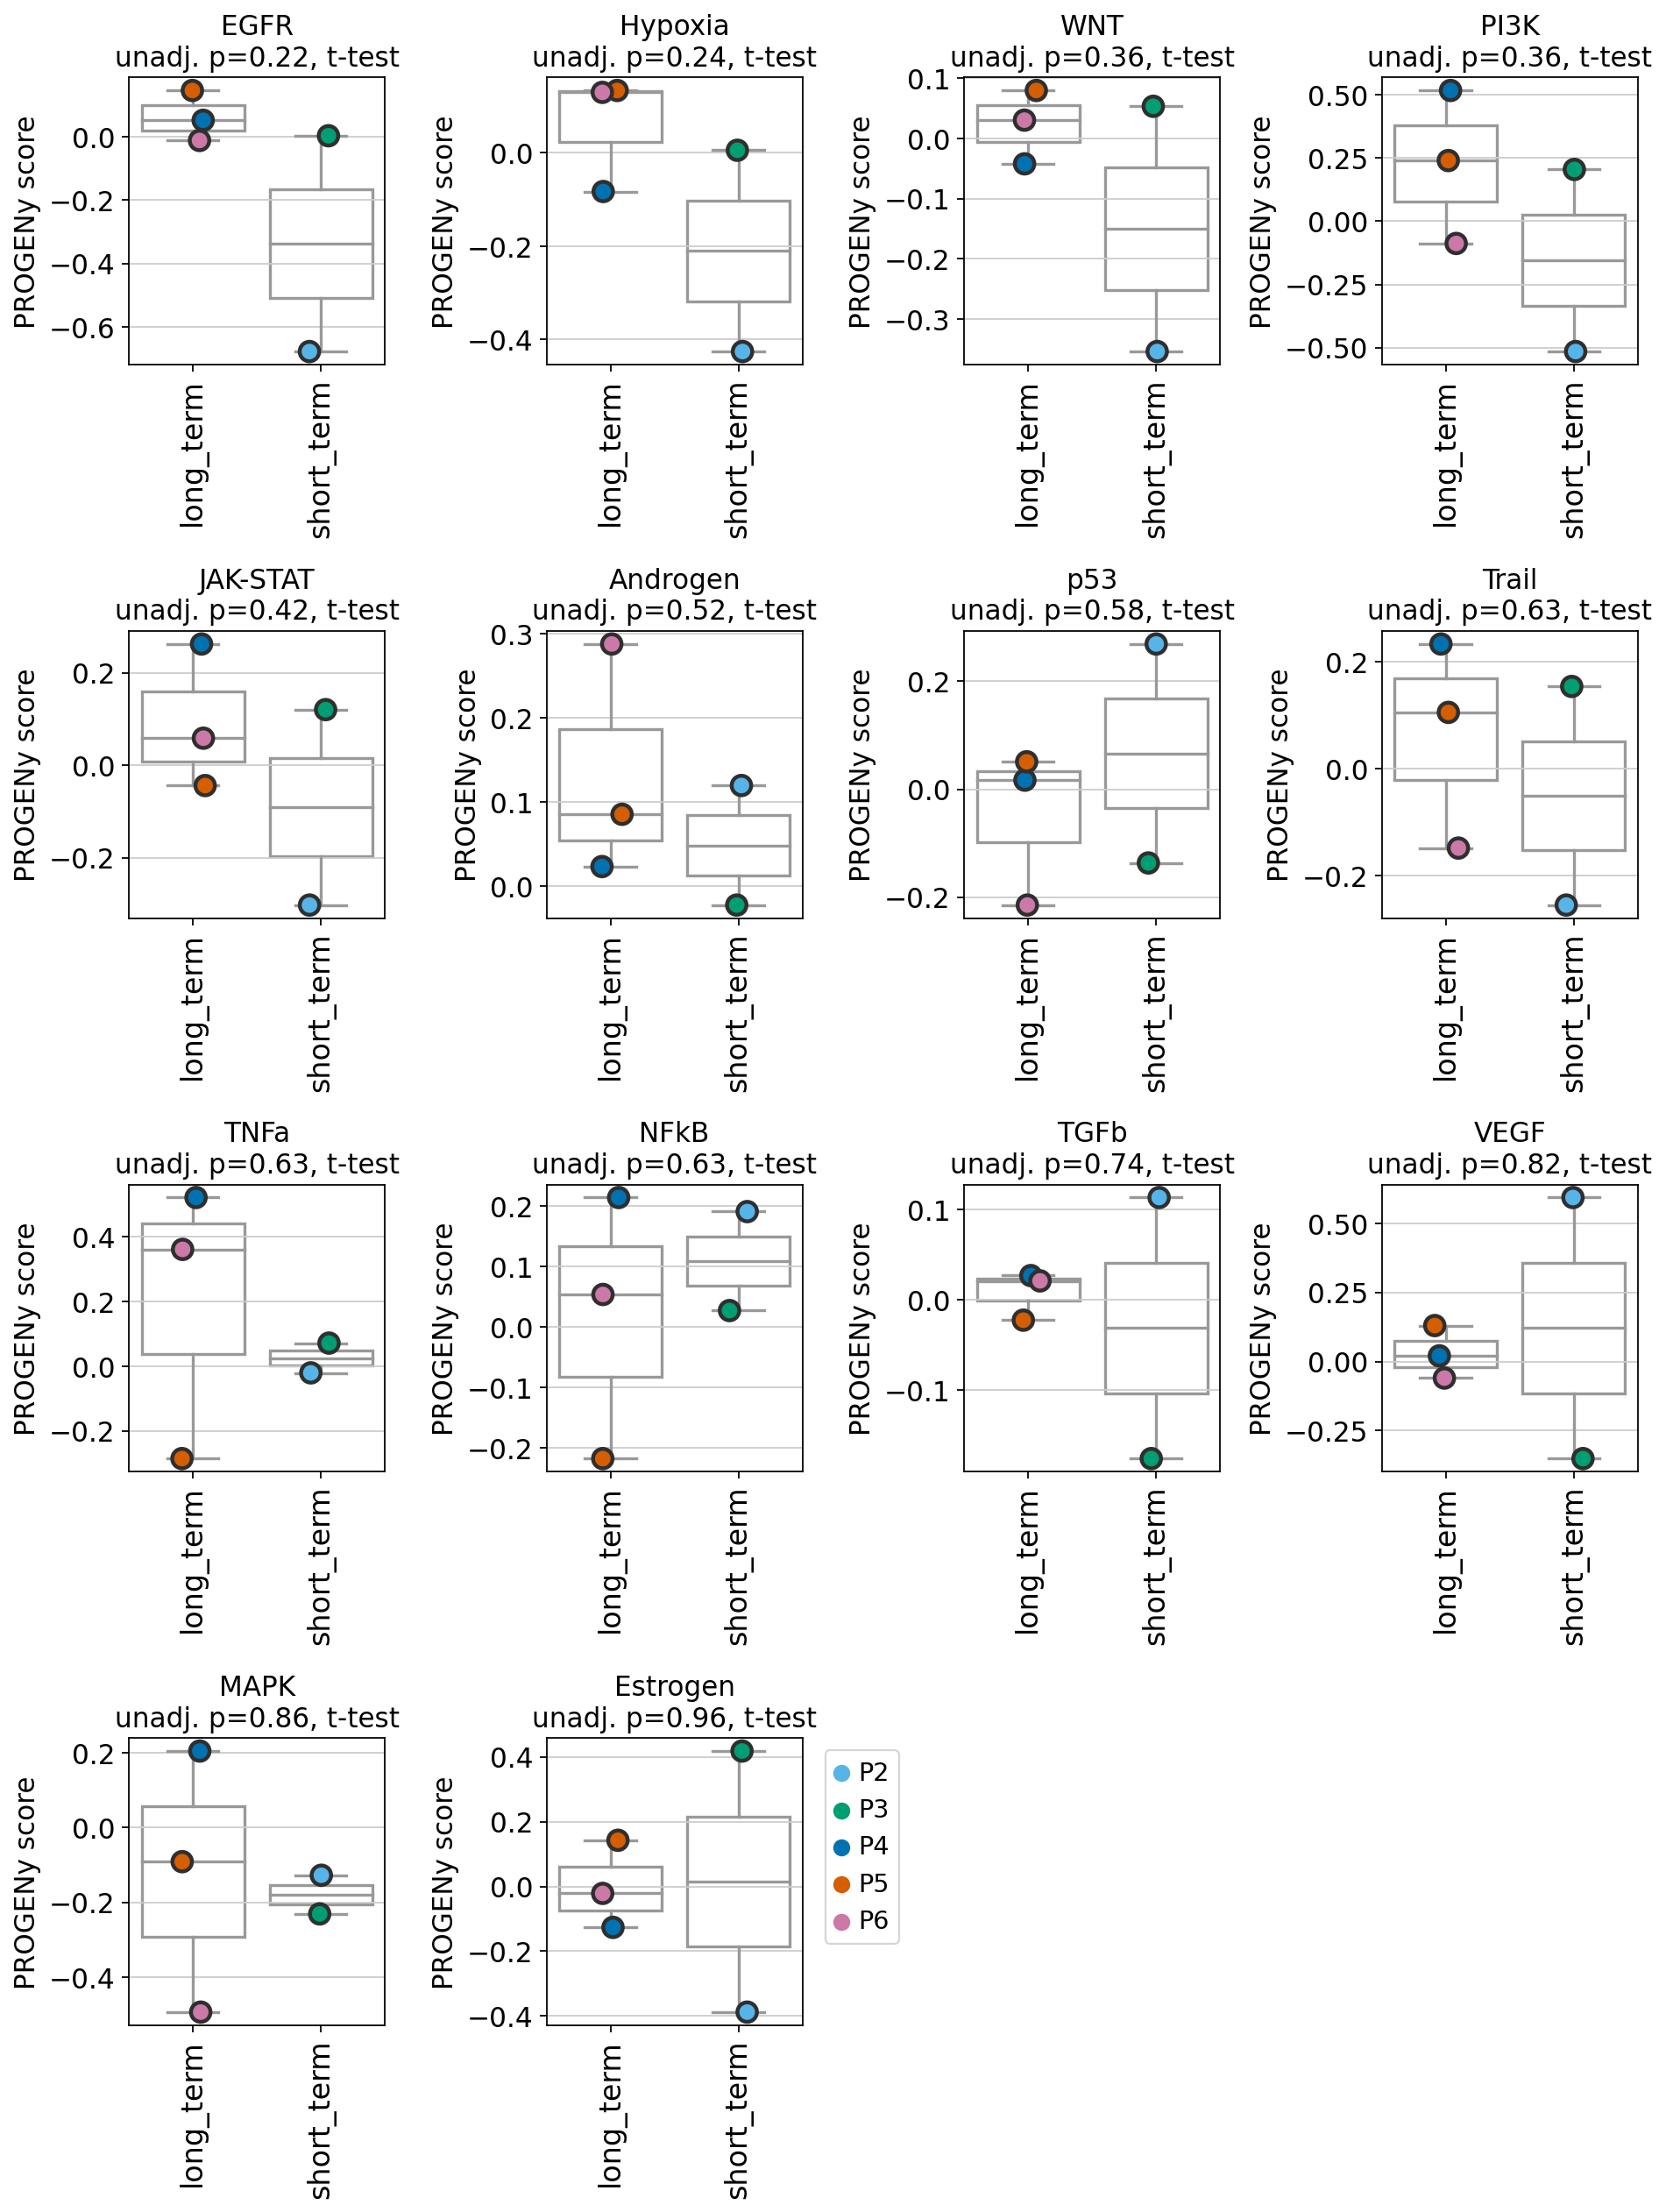

In [29]:
sns.set_palette(
    sns.color_palette(
        [sh.colors.COLORS.patient[p] for p in pb_pw_sr_lr.obs["patient"].unique()]
    )
)
fig = sh.pairwise.plot_paired(
    pb_pw_sr_lr,
    groupby="response",
    var_names=res["variable"].tolist(),
    ylabel="PROGENy score",
    pvalues=res["pvalue"].tolist(),
    boxplot_kwargs={"color": "white"},
    panel_size=(3, 4),
    rotate_x=90,
    hue="patient",
    return_fig=True,
)
fig.savefig(
    f"{artifact_dir}/progeny_long_term_vs_short_term_t0_paired_boxplot.pdf",
    bbox_inches="tight",
)

## malignant B vs Fos malignant B

In [30]:
progeny.run(
    adata_malignant_b,
    model,
    center=True,  # Center gene expression by mean per cell
    num_perm=0,  # Simulate m random activities
    norm=True,  # Normalize by number of edges to correct for large regulons
    scale=True,  # Scale values per feature so that values can be compared across cells
)

7353 genes found


In [31]:
adata_pw_malignant_b = progeny.extract(adata_malignant_b)

In [32]:
pb_pw_malignant_b = sh.pseudobulk.pseudobulk(
    adata_pw_malignant_b,
    aggr_fun=np.mean,
    groupby=["patient", "cell_phenotype"],
)

In [33]:
pb_pw_malignant_b.obs["cell_phenotype"] = pd.Categorical(
    pb_pw_malignant_b.obs["cell_phenotype"],
    categories=["malignant_b", "fos_malignant_b"],
)

In [34]:
pb_pw_malignant_b._sanitize()
sc.tl.pca(pb_pw_malignant_b)
sc.tl.dendrogram(
    pb_pw_malignant_b,
    groupby=["patient", "cell_phenotype"],
    use_rep="X_pca",
    linkage_method="average",
)

/data/scratch/sturm/conda/envs/2021-hairy-cell-leukemia-wolf-scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'patient' as categorical


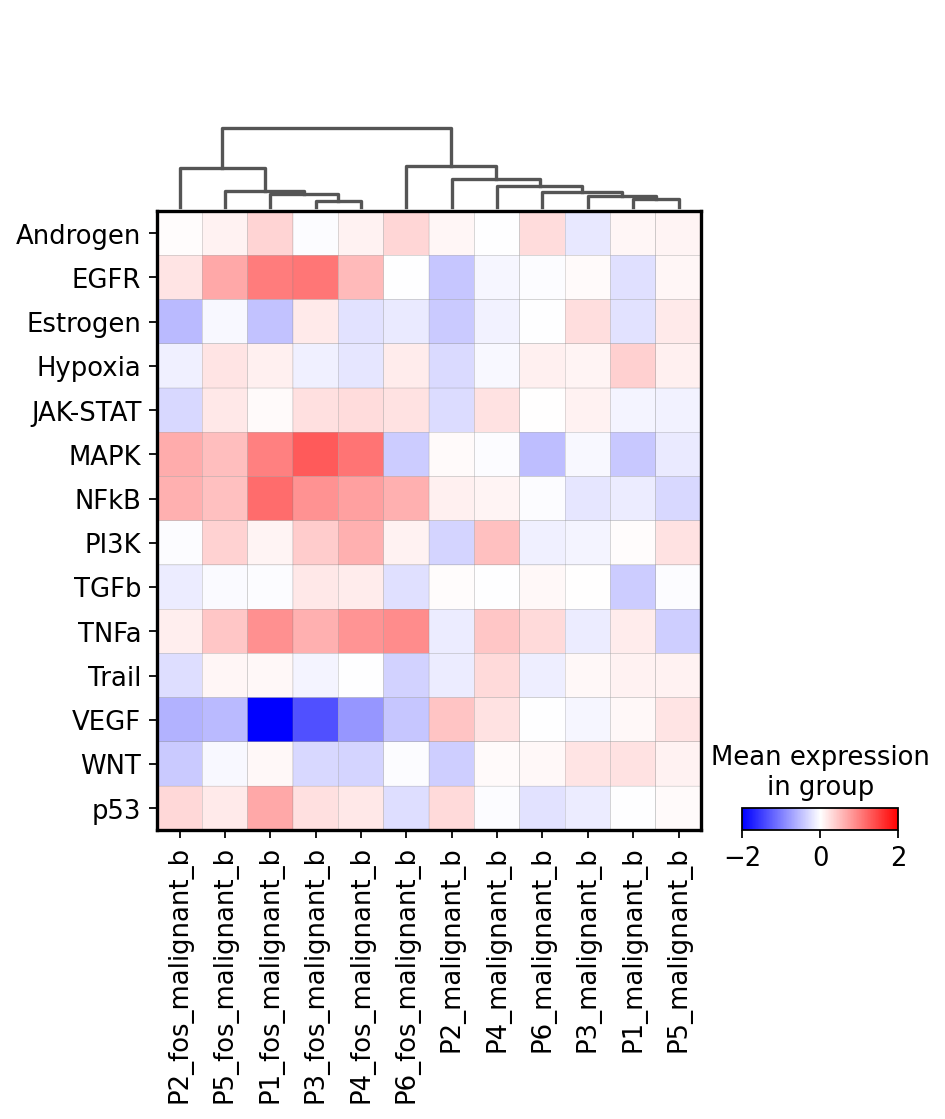

In [35]:
fig = sc.pl.matrixplot(
    pb_pw_malignant_b,
    var_names=pb_pw_malignant_b.var_names,
    groupby=["patient", "cell_phenotype"],
    cmap="bwr",
    swap_axes=True,
    dendrogram=True,
    vmin=-2,
    vmax=2,
    return_fig=True,
)
fig.savefig(
    f"{artifact_dir}/progeny_malignant_b_vs_fos_malignant_b_clustered_heatmap.pdf",
    bbox_inches="tight",
)

In [36]:
res = (
    sh.compare_groups.lm.test_lm(
        pb_pw_malignant_b,
        "~ C(cell_phenotype, Treatment('malignant_b')) + patient",
        groupby="cell_phenotype",
        contrasts="Treatment('malignant_b')",
    )
    .pipe(sh.util.fdr_correction)
    .sort_values("fdr")
)

  0%|          | 0/14 [00:00<?, ?it/s]

In [37]:
res

,coef,intercept,pvalue,variable,group,fdr
"C(cell_phenotype, Treatment('malignant_b'))[T.fos_malignant_b]",-0.161911,-0.265476,0.001354,Estrogen,fos_malignant_b,0.006319
"C(cell_phenotype, Treatment('malignant_b'))[T.fos_malignant_b]",0.823888,0.090705,0.001025,NFkB,fos_malignant_b,0.006319
"C(cell_phenotype, Treatment('malignant_b'))[T.fos_malignant_b]",0.601458,0.205189,0.001047,TNFa,fos_malignant_b,0.006319
"C(cell_phenotype, Treatment('malignant_b'))[T.fos_malignant_b]",-1.116307,-0.433328,0.004854,VEGF,fos_malignant_b,0.016990
"C(cell_phenotype, Treatment('malignant_b'))[T.fos_malignant_b]",0.872773,-0.153385,0.008369,MAPK,fos_malignant_b,0.023432
"C(cell_phenotype, Treatment('malignant_b'))[T.fos_malignant_b]",0.697992,0.042196,0.010731,EGFR,fos_malignant_b,0.025038
"C(cell_phenotype, Treatment('malignant_b'))[T.fos_malignant_b]",0.222137,-0.057997,0.016311,PI3K,fos_malignant_b,0.032349
"C(cell_phenotype, Treatment('malignant_b'))[T.fos_malignant_b]",-0.142393,0.151337,0.018485,Trail,fos_malignant_b,0.032349
"C(cell_phenotype, Treatment('malignant_b'))[T.fos_malignant_b]",0.128296,-0.087521,0.034477,JAK-STAT,fos_malignant_b,0.048268
"C(cell_phenotype, Treatment('malignant_b'))[T.fos_malignant_b]",-0.224132,0.251759,0.032971,WNT,fos_malignant_b,0.048268


In [38]:
ch = sh.compare_groups.pl.plot_lm_result_altair(res, p_cutoff=1)
ch.save(f"{artifact_dir}/progeny_malignant_b_vs_fos_malignant_b_lm_heatmap.svg")
ch.display()

WARN Channel size should not be used with an unsorted discrete field.


alt.LayerChart(...)

In [39]:
# reorder for proper ordering of legend
pb_pw_malignant_b = pb_pw_malignant_b[
    pb_pw_malignant_b.obs.sort_values(["patient", "cell_phenotype"]).index,
]
pb_pw

View of AnnData object with n_obs × n_vars = 11 × 14
    obs: 'patient', 'cell_type', 'n_obs'
    uns: 'pca', 'dendrogram_patient_cell_type'
    obsm: 'X_pca'
    varm: 'PCs'

In [40]:
ch = sh.pairwise.plot_paired_fc(
    pb_pw_malignant_b,
    groupby="cell_phenotype",
    paired_by="patient",
    metric="diff",
    var_names=res["variable"].tolist(),
    de_res_df=res,
    pvalue_col="fdr",
    var_col="variable",
)
ch.save(
    f"{artifact_dir}/progeny_malignant_b_vs_fos_malignant_b_fold_change_barchart.svg"
)
ch.display()

alt.LayerChart(...)

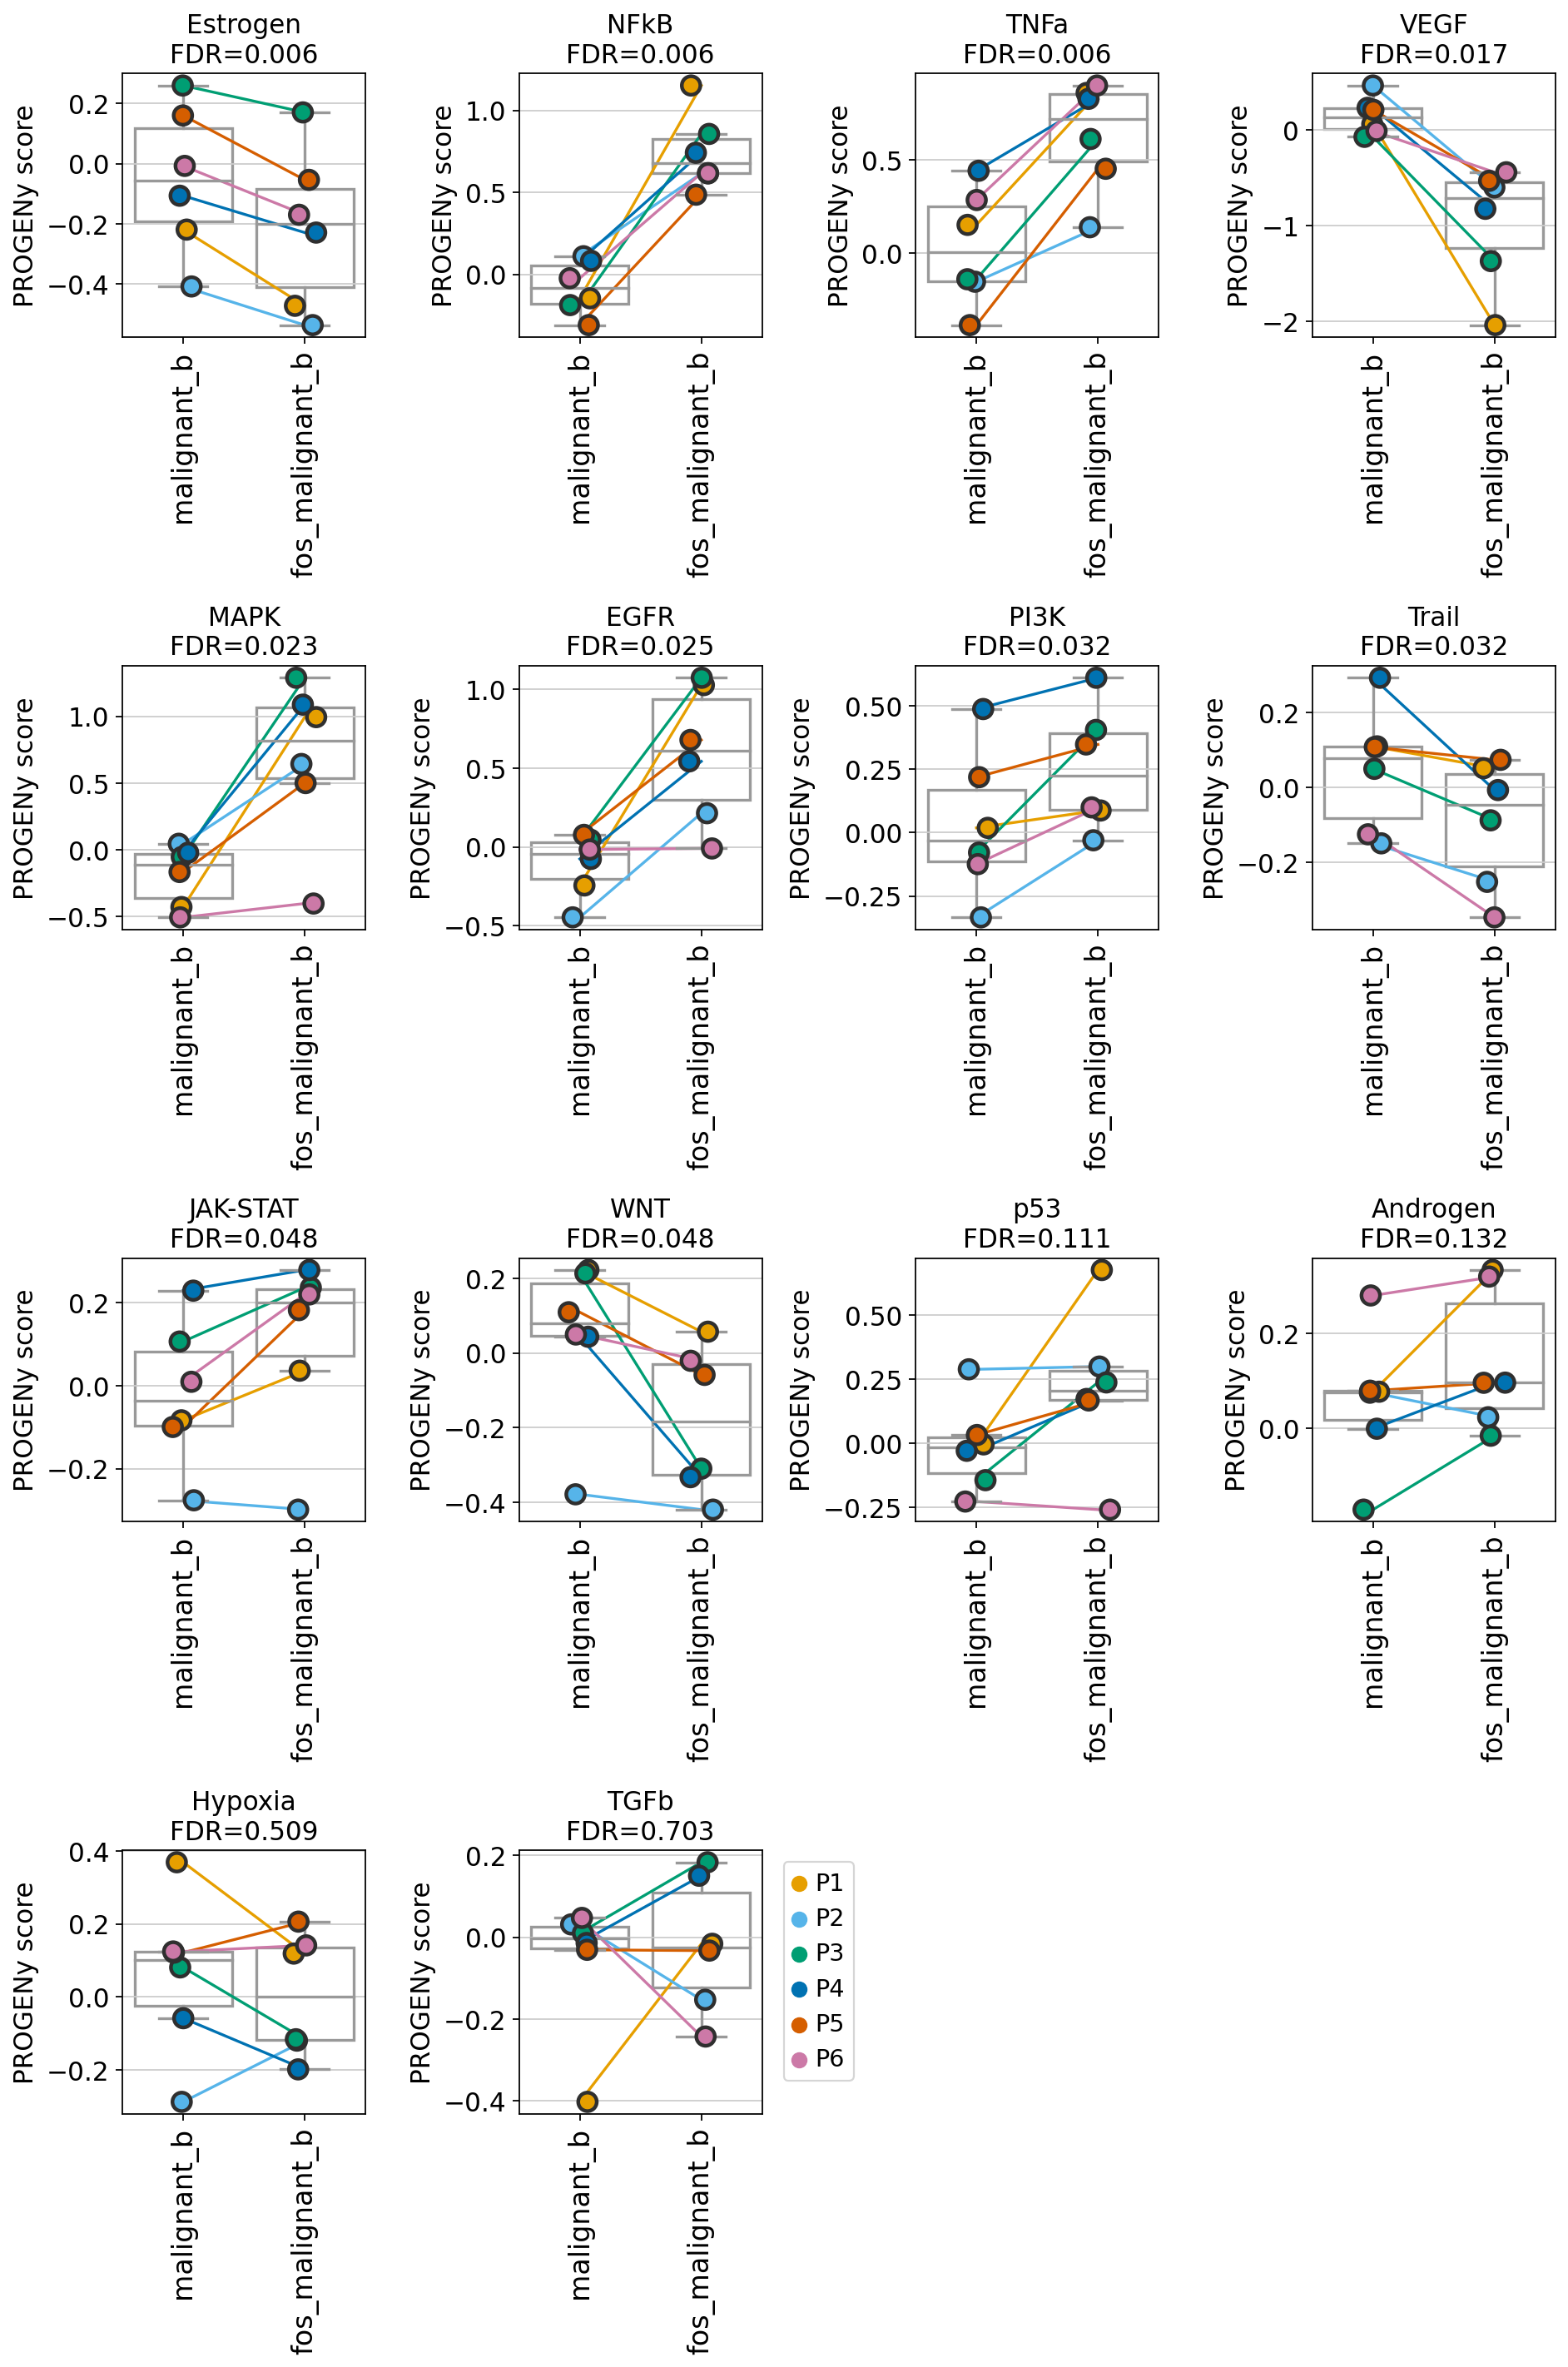

In [41]:
sns.set_palette(sns.color_palette(sh.colors.COLORS.patient.values()))
fig = sh.pairwise.plot_paired(
    pb_pw_malignant_b,
    groupby="cell_phenotype",
    paired_by="patient",
    var_names=res["variable"].tolist(),
    ylabel="PROGENy score",
    pvalues=res["fdr"].tolist(),
    pvalue_template="FDR={:.3f}",
    boxplot_kwargs={"color": "white"},
    panel_size=(3, 4.5),
    rotate_x=90,
    return_fig=True,
)
fig.savefig(
    f"{artifact_dir}/progeny_malignant_b_vs_fos_malignant_b_paired_boxplot.pdf",
    bbox_inches="tight",
)

# MSigDB pathways
Analysing subpathways of WNT and MAPK

In [42]:
signatures = dict(
    **sh.signatures.read_gmt("../../tables/c2.all.v7.5.1.symbols.gmt"),
    **sh.signatures.read_gmt("../../tables/c5.all.v7.5.1.symbols.gmt")
)

In [43]:
selected_wnt_pathways = [
    "GOBP_REGULATION_OF_WNT_SIGNALING_PATHWAY",
    "GOBP_POSITIVE_REGULATION_OF_WNT_SIGNALING_PATHWAY",
    "GOBP_NEGATIVE_REGULATION_OF_WNT_SIGNALING_PATHWAY",
    "GOBP_REGULATION_OF_CANONICAL_WNT_SIGNALING_PATHWAY",
    "GOBP_POSITIVE_REGULATION_OF_CANONICAL_WNT_SIGNALING_PATHWAY",
    "GOBP_NEGATIVE_REGULATION_OF_CANONICAL_WNT_SIGNALING_PATHWAY",
    "GOBP_REGULATION_OF_NON_CANONICAL_WNT_SIGNALING_PATHWAY",
    "GOBP_POSITIVE_REGULATION_OF_NON_CANONICAL_WNT_SIGNALING_PATHWAY",
    "GOBP_NEGATIVE_REGULATION_OF_NON_CANONICAL_WNT_SIGNALING_PATHWAY",
]

In [44]:
wnt_signatures = {
    s: g for s, g in signatures.items() if "wnt" in s.lower() and "GOBP_" in s
}
mapk_signatures = {
    s: g for s, g in signatures.items() if "mapk" in s.lower() and "GOBP_" in s
}

In [45]:
all_signatures = {**wnt_signatures, **mapk_signatures}

In [46]:
for signature, genes in tqdm(all_signatures.items()):
    sc.tl.score_genes(adata, genes, score_name=signature)

  0%|          | 0/32 [00:00<?, ?it/s]

In [47]:
adata_pw2 = sc.AnnData(
    adata.obs.loc[:, all_signatures.keys()],
    obs=adata.obs.drop(columns=all_signatures.keys()),
)

In [48]:
pb_pw2 = sh.pseudobulk.pseudobulk(
    adata_pw2[
        adata_pw2.obs["cell_type"].isin(["malignant B cell", "healthy B cell"]), :
    ],
    aggr_fun=np.mean,
    groupby=["patient", "cell_type"],
)
pb_pw2.obs["cell_type"] = pb_pw2.obs["cell_type"].str.replace(" cell", "")

In [49]:
pb_pw2._sanitize()

/data/scratch/sturm/conda/envs/2021-hairy-cell-leukemia-wolf-scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'patient' as categorical
/data/scratch/sturm/conda/envs/2021-hairy-cell-leukemia-wolf-scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


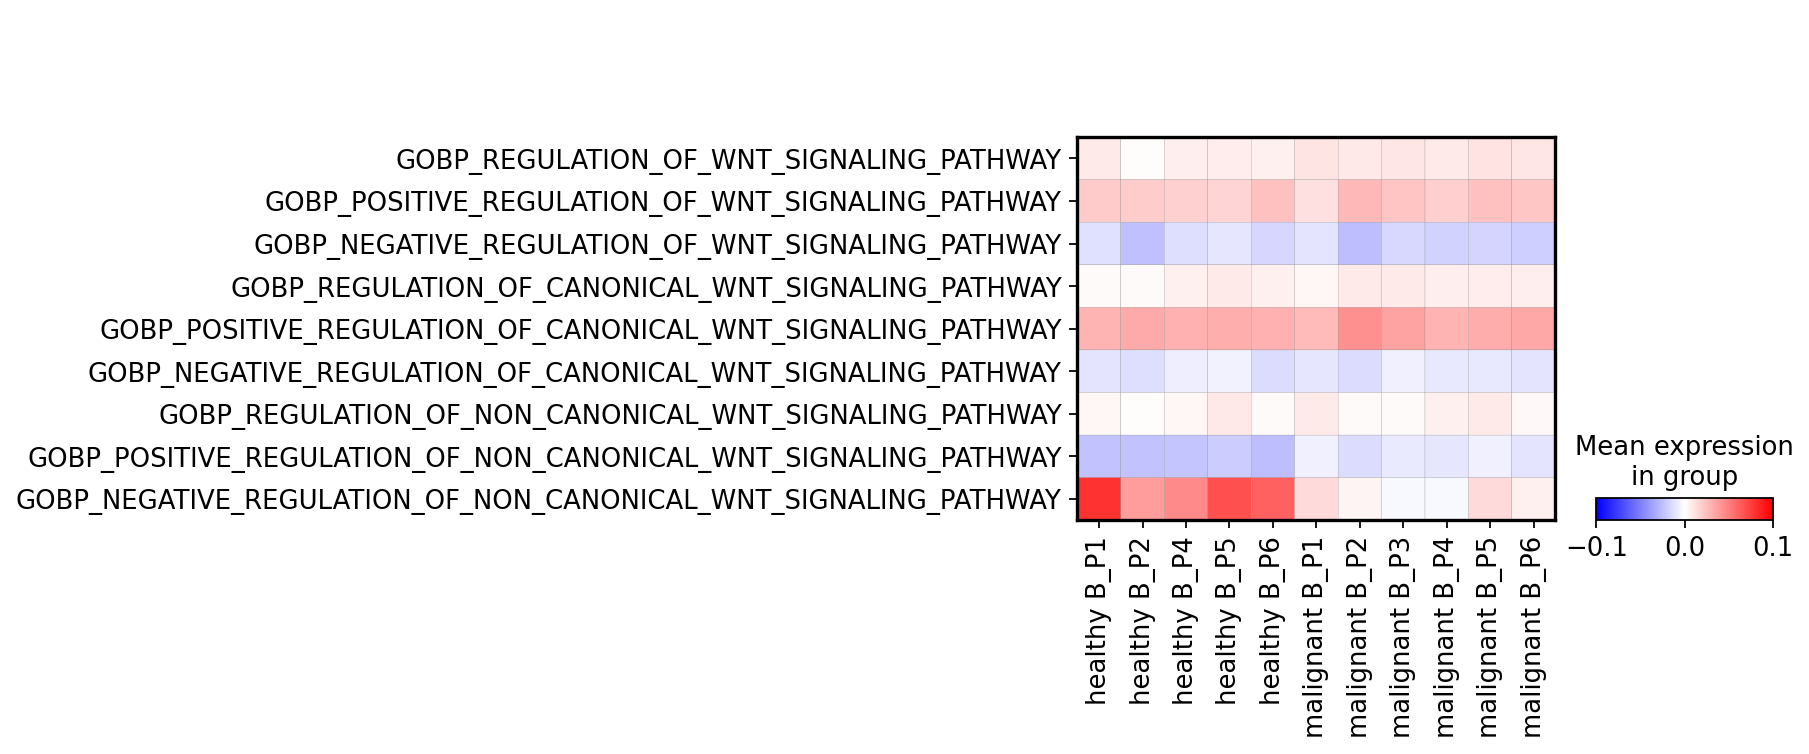

In [50]:
fig = sc.pl.matrixplot(
    pb_pw2,
    var_names=selected_wnt_pathways,
    groupby=["cell_type", "patient"],
    cmap="bwr",
    swap_axes=True,
    dendrogram=False,
    return_fig=True,
    vmax=0.1,
    vmin=-0.1,
)
fig.savefig(
    f"{artifact_dir}/gobp_wnt_healthy_vs_malignant_heatmap.pdf",
    bbox_inches="tight",
)

In [51]:
res = (
    sh.compare_groups.lm.test_lm(
        pb_pw2,
        "~ C(cell_type, Treatment('healthy B')) + patient",
        groupby="cell_type",
        contrasts="Treatment('healthy B')",
    )
    .pipe(sh.util.fdr_correction)
    .sort_values("fdr")
)

  0%|          | 0/32 [00:00<?, ?it/s]

In [52]:
tmp_res = res.loc[lambda x: x["variable"].isin(selected_wnt_pathways)].pipe(
    sh.util.fdr_correction
)
ch = sh.pairwise.plot_paired_fc(
    pb_pw2,
    groupby="cell_type",
    paired_by="patient",
    metric="diff",
    var_names=selected_wnt_pathways,
    de_res_df=tmp_res,
    pvalue_col="fdr",
    var_col="variable",
    swap_axes=True,
)
ch.save(f"{artifact_dir}/gobp_wnt_healthy_vs_malignant_barchart.svg")
ch.display()

/home/sturm/projects/2021/hairy_cell_leukemia_wolf/lib/scanpy_helpers/scanpy_helpers/pairwise.py:80: UserWarning: 1 unpaired samples removed
  warnings.warn(f"{removed_samples} unpaired samples removed")


alt.LayerChart(...)

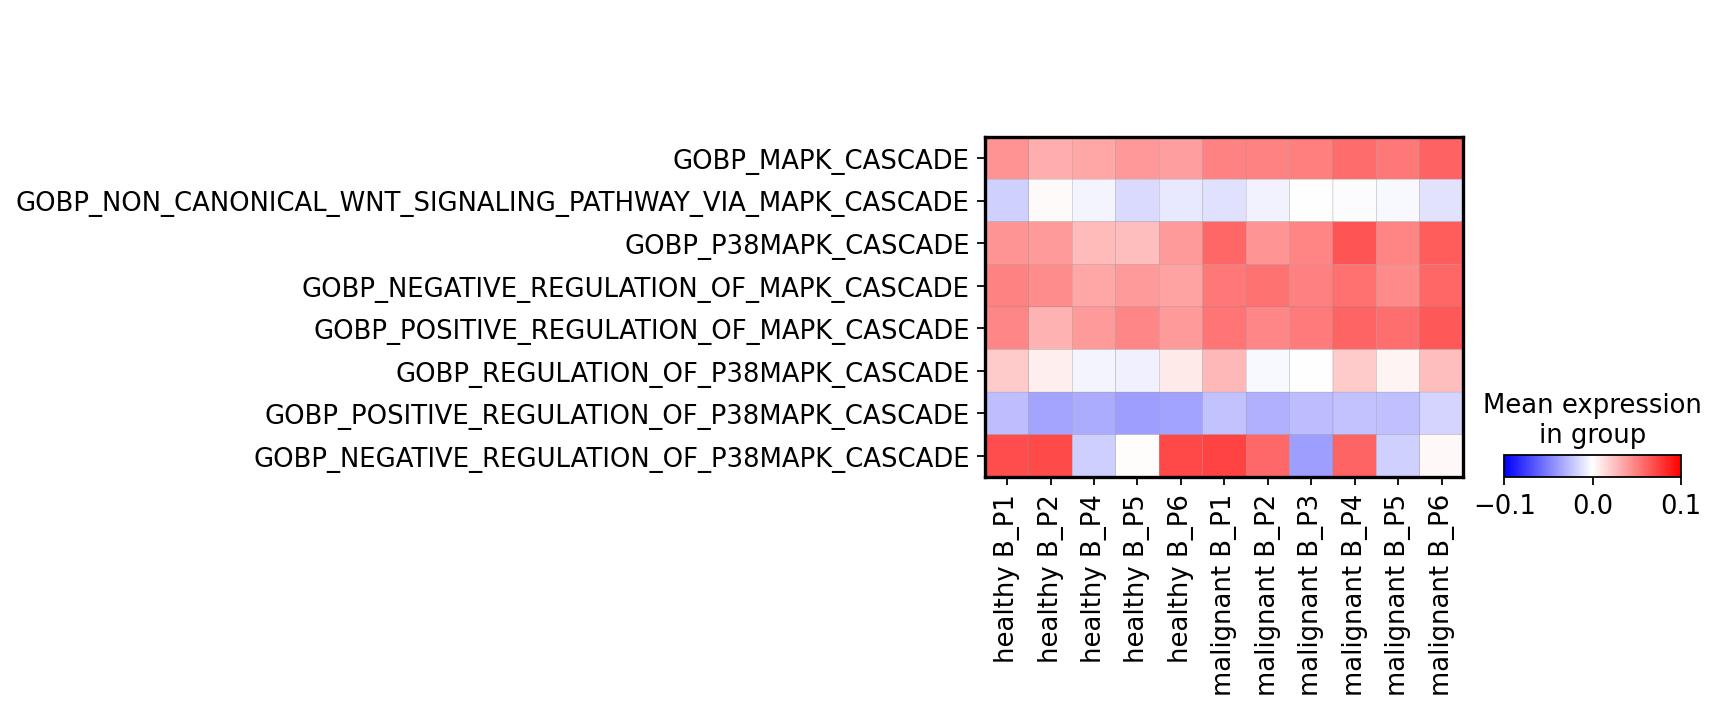

In [53]:
fig = sc.pl.matrixplot(
    pb_pw2,
    var_names=list(mapk_signatures.keys()),
    groupby=["cell_type", "patient"],
    cmap="bwr",
    swap_axes=True,
    dendrogram=False,
    return_fig=True,
    vmin=-0.1,
    vmax=0.1,
)
fig.savefig(
    f"{artifact_dir}/gobp_mapk_healthy_vs_malignant_heatmap.pdf",
    bbox_inches="tight",
)

In [54]:
tmp_res = res.loc[lambda x: x["variable"].isin(mapk_signatures.keys())].pipe(
    sh.util.fdr_correction
)
ch = sh.pairwise.plot_paired_fc(
    pb_pw2,
    groupby="cell_type",
    paired_by="patient",
    metric="diff",
    var_names=list(mapk_signatures.keys()),
    de_res_df=tmp_res,
    pvalue_col="fdr",
    var_col="variable",
    swap_axes=True,
)
ch.save(f"{artifact_dir}/gobp_mapk_healthy_vs_malignant_barchart.svg")
ch.display()

/home/sturm/projects/2021/hairy_cell_leukemia_wolf/lib/scanpy_helpers/scanpy_helpers/pairwise.py:80: UserWarning: 1 unpaired samples removed
  warnings.warn(f"{removed_samples} unpaired samples removed")


alt.LayerChart(...)

## SR vs LR T0

In [55]:
pb_pw_sr_lr2 = sh.pseudobulk.pseudobulk(
    adata_pw2[
        (adata_pw2.obs["timepoint"] == "T0")
        & (adata_pw2.obs["cell_type"] == "malignant B cell"),
        :,
    ],
    groupby=["patient", "response"],
    aggr_fun=np.mean,
)

In [56]:
pb_pw_sr_lr2.obs

,patient,response,n_obs
0,P2,short_term,3353
1,P4,long_term,3824
2,P6,long_term,4253
3,P3,short_term,1109
4,P5,long_term,5292


In [57]:
pb_pw_sr_lr2.obs["patient"] = pb_pw_sr_lr2.obs["patient"].astype("category")

/data/scratch/sturm/conda/envs/2021-hairy-cell-leukemia-wolf-scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'response' as categorical


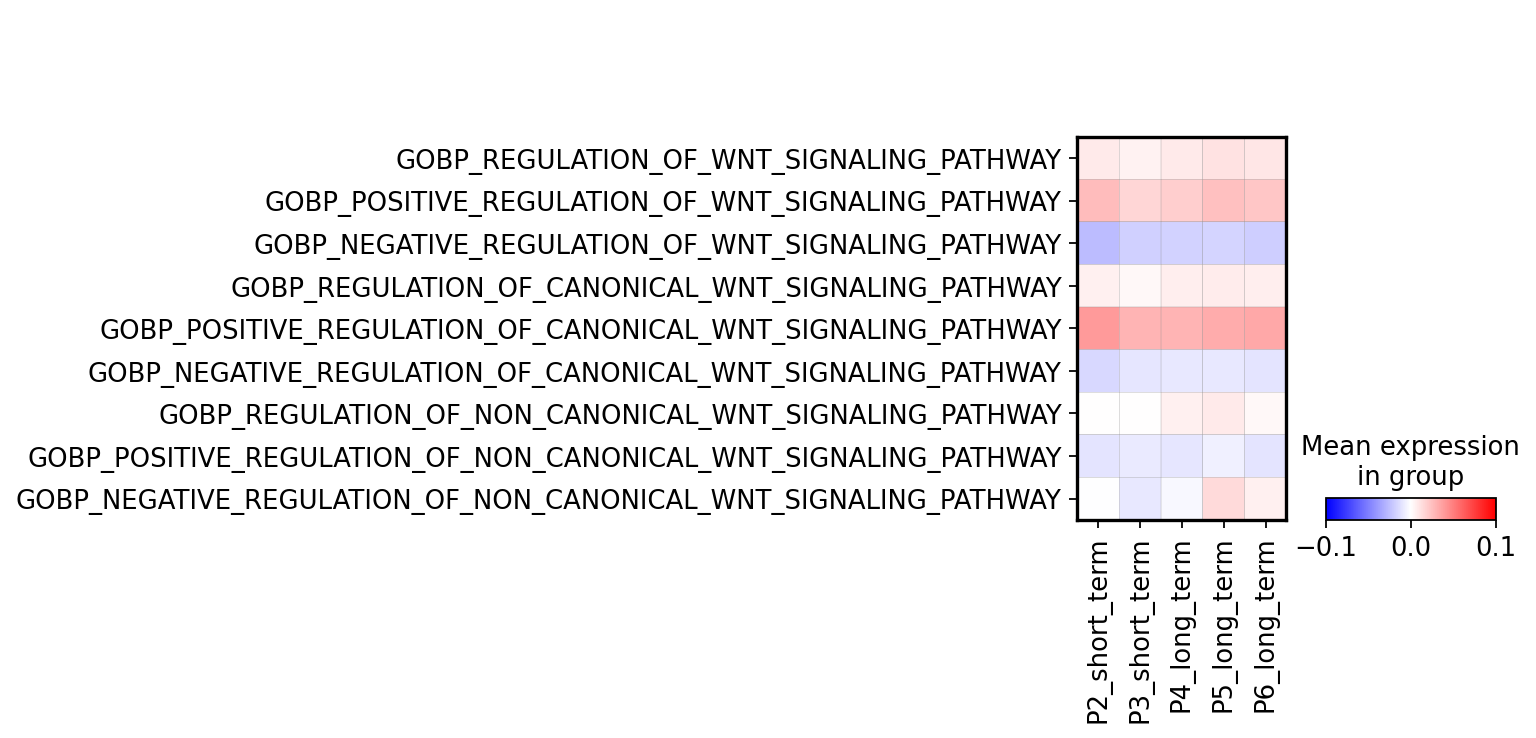

In [58]:
fig = sc.pl.matrixplot(
    pb_pw_sr_lr2,
    var_names=selected_wnt_pathways,
    groupby=["patient", "response"],
    cmap="bwr",
    swap_axes=True,
    dendrogram=False,
    return_fig=True,
    vmax=0.1,
    vmin=-0.1,
)
fig.savefig(
    f"{artifact_dir}/gobp_wnt_long_term_short_term_t0_heatmap.pdf",
    bbox_inches="tight",
)

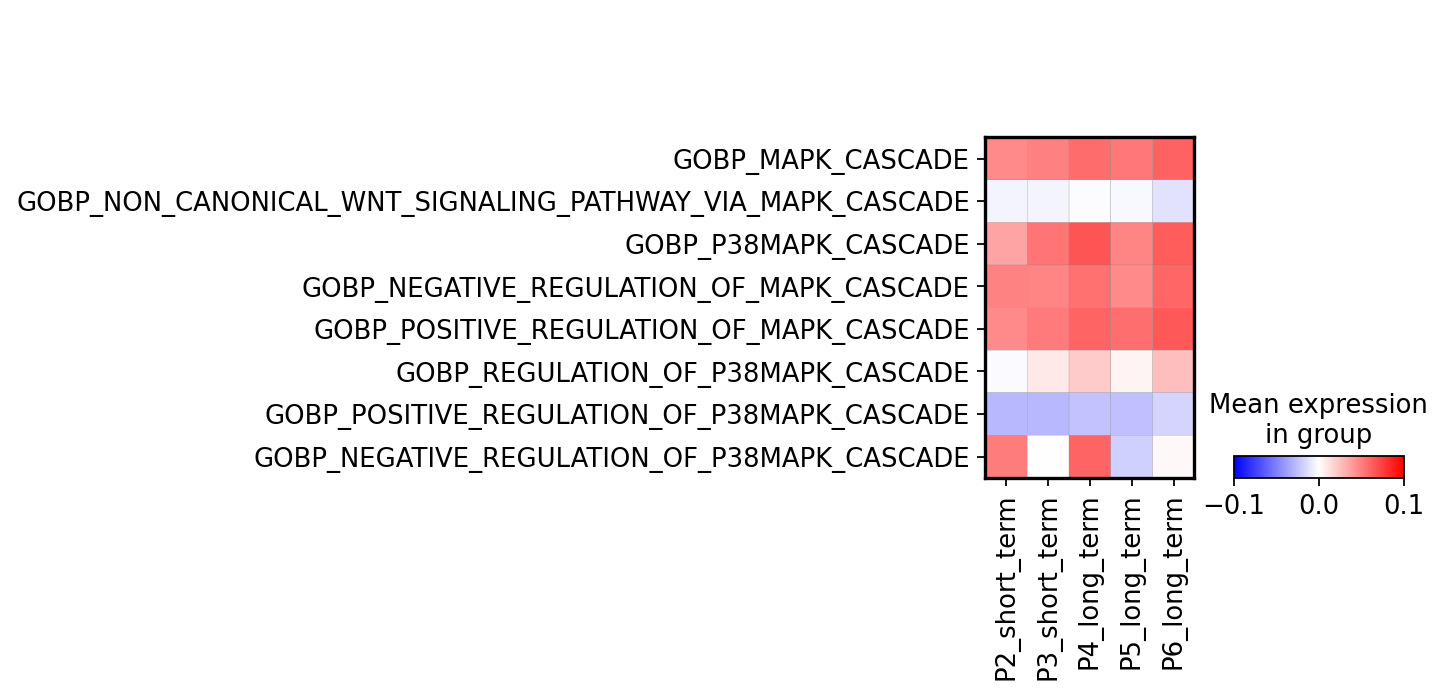

In [59]:
fig = sc.pl.matrixplot(
    pb_pw_sr_lr2,
    var_names=list(mapk_signatures.keys()),
    groupby=["patient", "response"],
    cmap="bwr",
    swap_axes=True,
    dendrogram=False,
    return_fig=True,
    vmax=0.1,
    vmin=-0.1,
)
fig.savefig(
    f"{artifact_dir}/gobp_mapk_long_term_short_term_t0_heatmap.pdf",
    bbox_inches="tight",
)

## malignant B vs Fos malignant B

In [60]:
for signature, genes in tqdm(all_signatures.items()):
    sc.tl.score_genes(adata_malignant_b, genes, score_name=signature)

  0%|          | 0/32 [00:00<?, ?it/s]

In [61]:
adata_malignant_b_pw2 = sc.AnnData(
    adata_malignant_b.obs.loc[:, all_signatures.keys()],
    obs=adata_malignant_b.obs.drop(columns=all_signatures.keys()),
)

In [62]:
pb_pw_malignant_b2 = sh.pseudobulk.pseudobulk(
    adata_malignant_b_pw2,
    aggr_fun=np.mean,
    groupby=["patient", "cell_phenotype"],
)

In [63]:
pb_pw_malignant_b2.obs["cell_phenotype"] = pd.Categorical(
    pb_pw_malignant_b2.obs["cell_phenotype"],
    categories=["malignant_b", "fos_malignant_b"],
)

/data/scratch/sturm/conda/envs/2021-hairy-cell-leukemia-wolf-scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'patient' as categorical


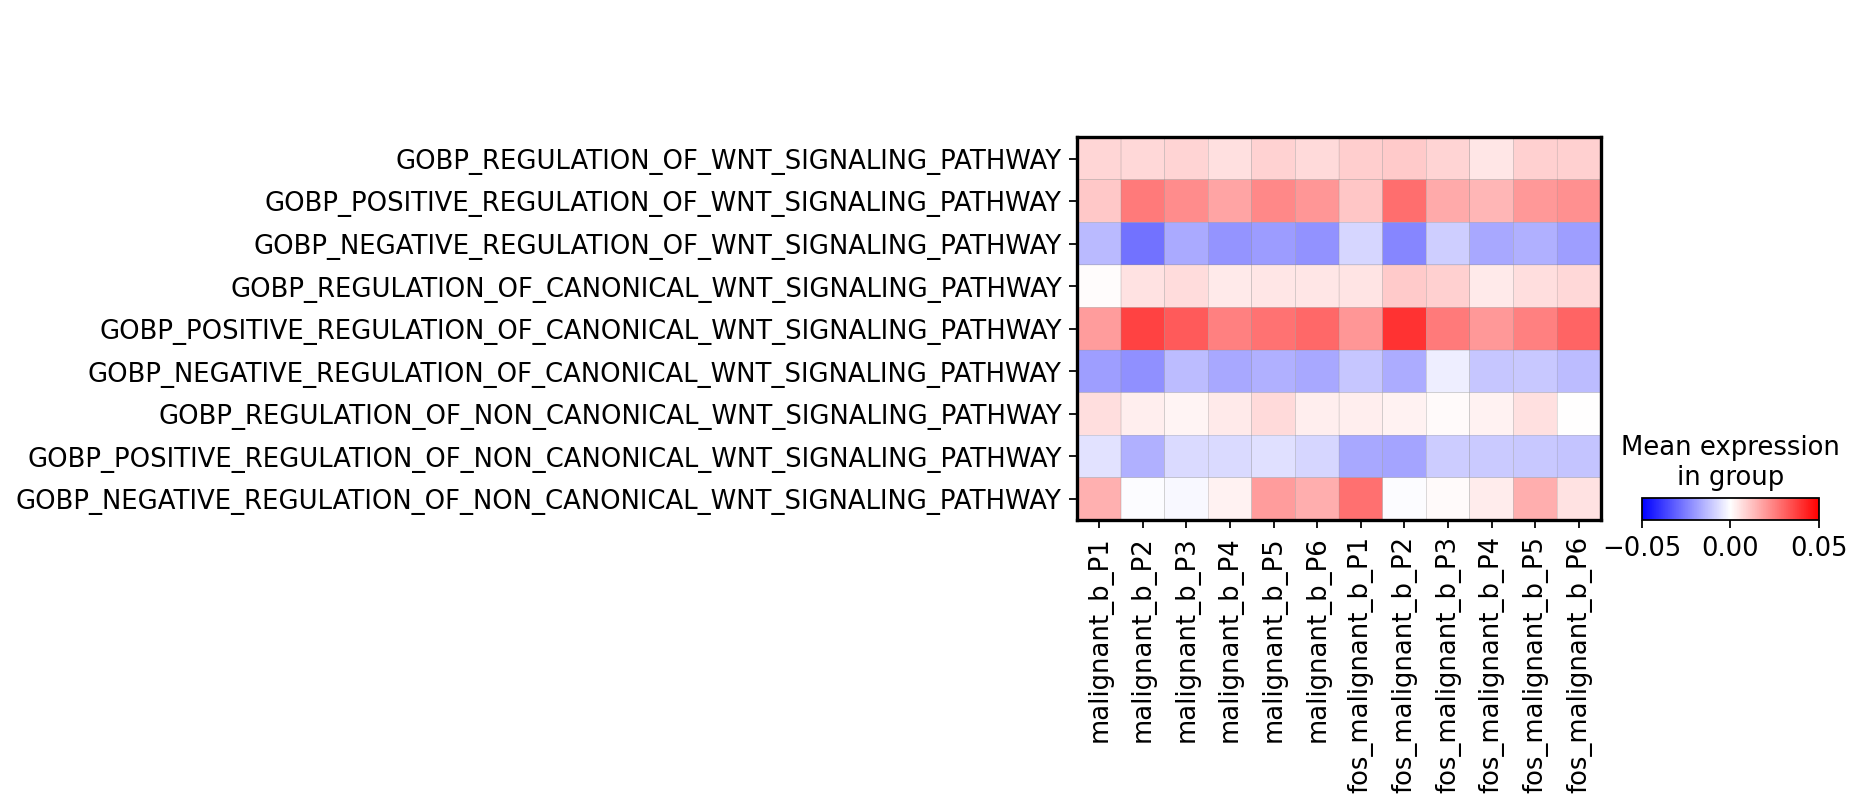

In [64]:
fig = sc.pl.matrixplot(
    pb_pw_malignant_b2,
    var_names=selected_wnt_pathways,
    groupby=["cell_phenotype", "patient"],
    cmap="bwr",
    swap_axes=True,
    dendrogram=False,
    vmin=-0.05,
    vmax=0.05,
    return_fig=True,
)
fig.savefig(
    f"{artifact_dir}/gobp_wnt_malignant_b_vs_fos_malignant_b_heatmap.pdf",
    bbox_inches="tight",
)

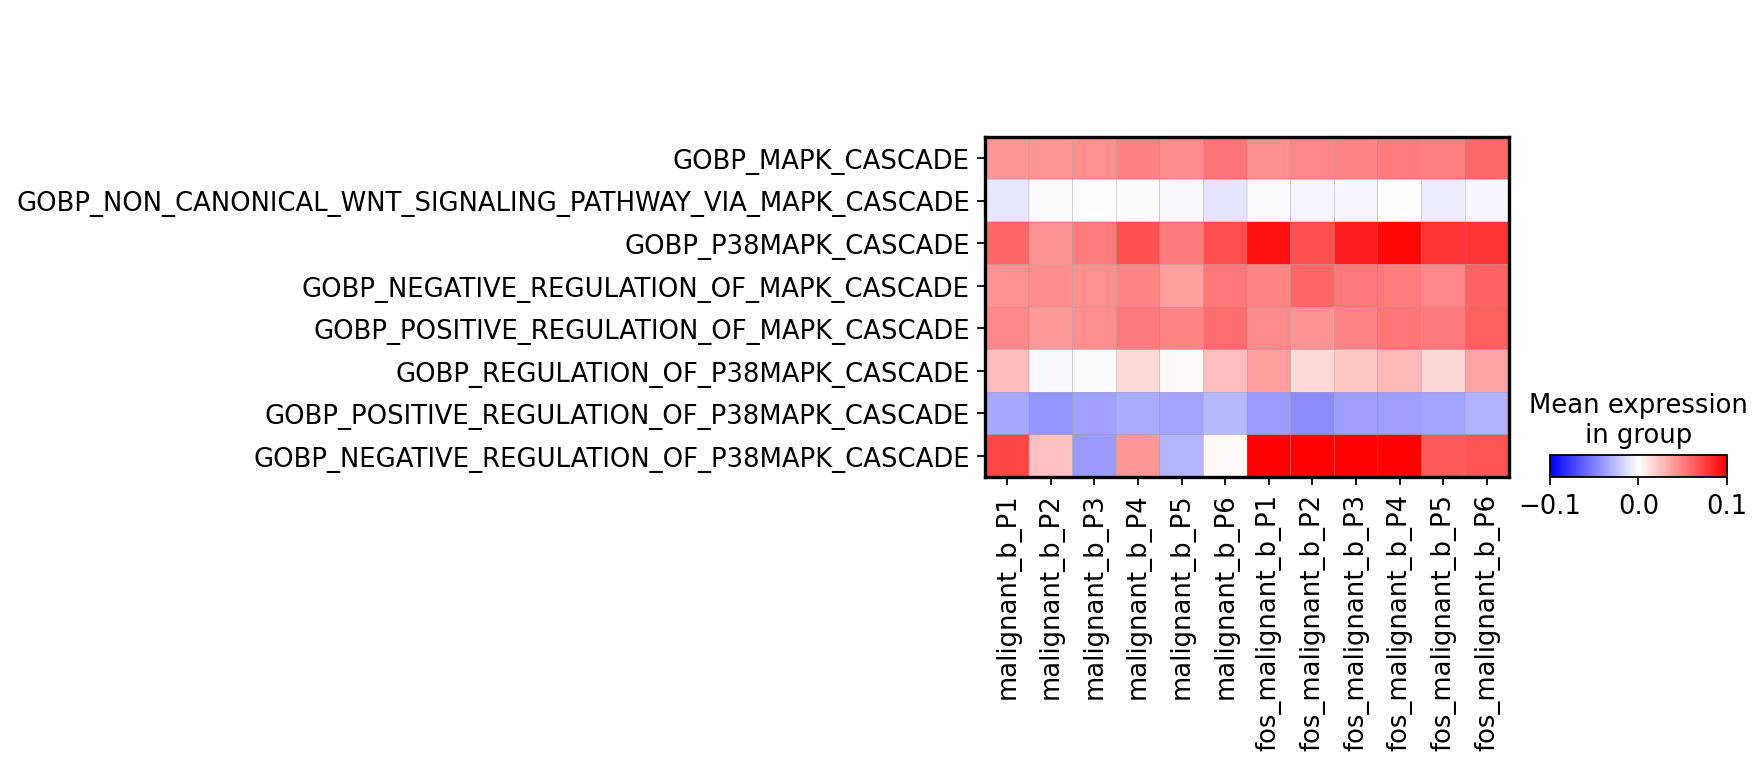

In [65]:
fig = sc.pl.matrixplot(
    pb_pw_malignant_b2,
    var_names=list(mapk_signatures.keys()),
    groupby=["cell_phenotype", "patient"],
    cmap="bwr",
    swap_axes=True,
    dendrogram=False,
    vmin=-0.1,
    vmax=0.1,
    return_fig=True,
)
fig.savefig(
    f"{artifact_dir}/gobp_mapk_malignant_b_vs_fos_malignant_b_heatmap.pdf",
    bbox_inches="tight",
)

In [66]:
res = (
    sh.compare_groups.lm.test_lm(
        pb_pw_malignant_b2,
        "~ C(cell_phenotype, Treatment('malignant_b')) + patient",
        groupby="cell_phenotype",
        contrasts="Treatment('malignant_b')",
    )
    .pipe(sh.util.fdr_correction)
    .sort_values("fdr")
)

  0%|          | 0/32 [00:00<?, ?it/s]

In [67]:
tmp_res = res.loc[lambda x: x["variable"].isin(selected_wnt_pathways)].pipe(
    sh.util.fdr_correction
)
ch = sh.pairwise.plot_paired_fc(
    pb_pw_malignant_b2,
    groupby="cell_phenotype",
    paired_by="patient",
    metric="diff",
    var_names=selected_wnt_pathways,
    de_res_df=tmp_res,
    pvalue_col="fdr",
    var_col="variable",
    swap_axes=True,
)
ch.save(f"{artifact_dir}/gobp_wnt_malignant_b_vs_fos_malignant_b_barchart.svg")
ch.display()

alt.LayerChart(...)

In [68]:
tmp_res = res.loc[lambda x: x["variable"].isin(mapk_signatures.keys())].pipe(
    sh.util.fdr_correction
)
ch = sh.pairwise.plot_paired_fc(
    pb_pw_malignant_b2,
    groupby="cell_phenotype",
    paired_by="patient",
    metric="diff",
    var_names=list(mapk_signatures.keys()),
    de_res_df=tmp_res,
    pvalue_col="fdr",
    var_col="variable",
    swap_axes=True,
)
ch.save(f"{artifact_dir}/gobp_mapk_malignant_b_vs_fos_malignant_b_barchart.svg")
ch.display()

alt.LayerChart(...)